In [1]:
# !pip install tensorflow==1.13.1
!pip install tensorflow==1.14.0
# !pip install keras==2.2.5
!pip install keras==2.0.8
!pip install h5py==2.10.0
#!pip install 'tensorflow-estimator<1.15.0rc0,>=1.14.0rc0' --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 49 kB/s 
     |████████████████████████████████| 50 kB 8.1 MB/s 
     |████████████████████████████████| 488 kB 72.2 MB/s 
     |████████████████████████████████| 3.1 MB 53.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
    Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
ERROR: pip's dependency resolver does not currently ta

In [2]:
# %tensorflow_version 1.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  #TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))



After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Found GPU at: /device:GPU:0


In [3]:
# import kaggle.json from local device and create a folder data
!mkdir data
!mkdir ~/.kaggle/

In [4]:
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c imaterialist-fashion-2019-FGVC6
#!unzip /content/imaterialist-fashion-2019-FGVC6.zip



100% 19.1G/19.1G [06:23<00:00, 80.3MB/s]
100% 19.1G/19.1G [06:23<00:00, 53.4MB/s]


In [ ]:
!unzip /content/imaterialist-fashion-2019-FGVC6.zip 'train/*'
!unzip /content/imaterialist-fashion-2019-FGVC6.zip 'label_descriptions.json'
# !unzip /content/imaterialist-fashion-2019-FGVC6.zip 'train.csv'
!unzip /content/imaterialist-fashion-2019-FGVC6.zip 'sample_submission.csv'

unzip:  cannot find or open /content/imaterialist-fashion-2019-FGVC6.zip, /content/imaterialist-fashion-2019-FGVC6.zip.zip or /content/imaterialist-fashion-2019-FGVC6.zip.ZIP.
unzip:  cannot find or open /content/imaterialist-fashion-2019-FGVC6.zip, /content/imaterialist-fashion-2019-FGVC6.zip.zip or /content/imaterialist-fashion-2019-FGVC6.zip.ZIP.
unzip:  cannot find or open /content/imaterialist-fashion-2019-FGVC6.zip, /content/imaterialist-fashion-2019-FGVC6.zip.zip or /content/imaterialist-fashion-2019-FGVC6.zip.ZIP.


In [ ]:
!rm  /content/imaterialist-fashion-2019-FGVC6.zip
!mv /content/train /content/data
# !mv /content/test /content/data
!mv /content/label_descriptions.json /content/data
!mv /content/sample_submission.csv /content/data


rm: cannot remove '/content/imaterialist-fashion-2019-FGVC6.zip': No such file or directory
mv: cannot stat '/content/train': No such file or directory
mv: cannot stat '/content/label_descriptions.json': No such file or directory
mv: cannot stat '/content/sample_submission.csv': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/train.csv.zip
#!unzip /content/drive/MyDrive/fashion20220503T0125.zip
!mv /content/train.csv /content/data

Archive:  /content/drive/MyDrive/train.csv.zip
  inflating: train.csv               


In [10]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

In [11]:
DATA_DIR = Path('/content/data')
ROOT_DIR = Path('/content')

# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks
NUM_CATS = 46
IMAGE_SIZE = 512

# Dowload Libraries and Pretrained Weights

In [12]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
#!git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 17.26 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [13]:
sys.path.append('Mask_RCNN')
!ls

LICENSE      mrcnn	requirements.txt  setup.cfg
MANIFEST.in  README.md	samples		  setup.py


In [14]:
!pip install -r requirements.txt
!python setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 298 kB 41.4 MB/s 
     |████████████████████████████████| 154 kB 71.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=1c6028ad8409d438e657cbf331168424fc7e670cbeb3d52dda0852c827967d59
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.2 which is incompatible.


/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'ma

In [15]:
#sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import keras.engine as KE
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [16]:
%load_ext autoreload
%autoreload 2

In [ ]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Dec  6 18:58 mask_rcnn_coco.h5


# Set Config

Mask R-CNN has a load of hyperparameters. I only adjust some of them.

In [20]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # a memory error occurs when IMAGES_PER_GPU is too high
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

# Make Datasets

In [ ]:
!ls


build  LICENSE	    mask_rcnn_coco.h5	mrcnn	   requirements.txt  setup.cfg
dist   MANIFEST.in  mask_rcnn.egg-info	README.md  samples	     setup.py


In [29]:
with open(DATA_DIR/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [ ]:
segment_df = pd.read_csv(DATA_DIR/"train.csv")

multilabel_percent = len(segment_df[segment_df['ClassId'].str.contains('_')])/len(segment_df)*100
print(f"Segments that have attributes: {multilabel_percent:.2f}%")

Segments that contain attributes are only 3.46% of data, and [according to the host](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/90643#523135), 80% of images have no attribute. So, in the first step, we can only deal with categories to reduce the complexity of the task.

In [ ]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  331213


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


Rows with the same image are grouped together because the subsequent operations perform in an image level.

In [ ]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Total images:  45195


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214.0,3676.0
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448.0,2448.0
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000.0,1997.0
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567.0,400.0
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750.0,500.0


Here is the custom function that resizes an image.

In [17]:
import os.path
from os import path

def resize_image(image_path):
  if path.exists(image_path) :
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img
  else :
    print("false")

The crucial part is to create a dataset for this task.

In [ ]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/'train'/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=int(row['Height']), width=int(row['Width']))

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

In [ ]:
dataset = FashionDataset(image_df)
dataset.prepare()
dataset.image_ids.dtype

dtype('int64')

Let's visualize some random images and their masks.

('/content/data/train/13d0a3e9995e0ab2d84a0de5018c87ab.jpg', ['buckle', 'belt', 'pocket', 'pocket', 'pants', 'shoe', 'shoe', 'sleeve', 'sleeve', 'neckline', 'top, t-shirt, sweatshirt'])


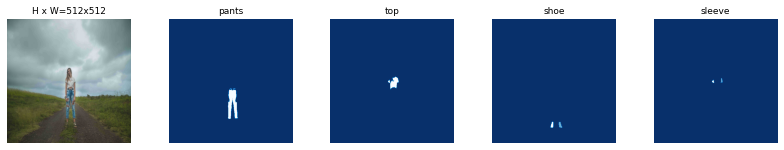

('/content/data/train/4004585aa7dc919f0ab04e6376355e27.jpg', ['dress', 'sleeve', 'sleeve', 'neckline', 'bead', 'bead', 'bead', 'bead', 'bead', 'bag, wallet'])


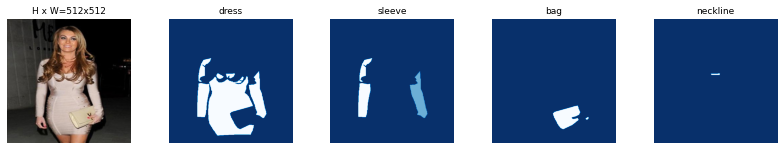

('/content/data/train/1fa9d451265aabf2f226f3d66b50be24.jpg', ['sleeve', 'lapel', 'pocket', 'tie', 'collar', 'sleeve', 'jacket', 'shirt, blouse', 'pants', 'shoe', 'shoe'])


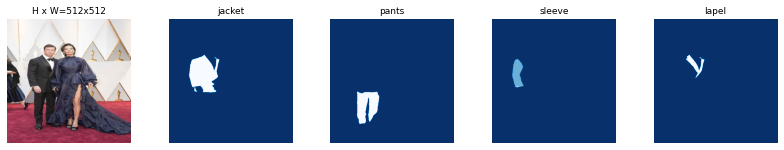

('/content/data/train/6d72c5e6bc0b956a5332fead0f01bf46.jpg', ['neckline', 'dress', 'shoe', 'shoe'])


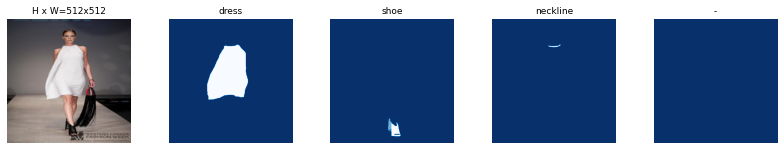

('/content/data/train/2992bc3107c5b34353ee3009a31935f6.jpg', ['top, t-shirt, sweatshirt', 'skirt', 'neckline'])


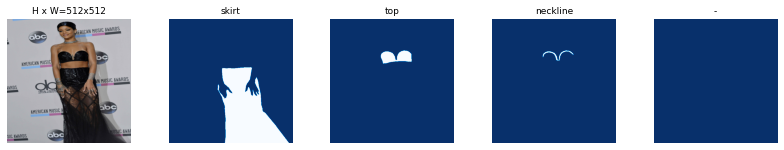

('/content/data/train/924b6bf874af75d61212b15f7d9aaee6.jpg', ['belt', 'hat', 'dress', 'lapel', 'belt'])


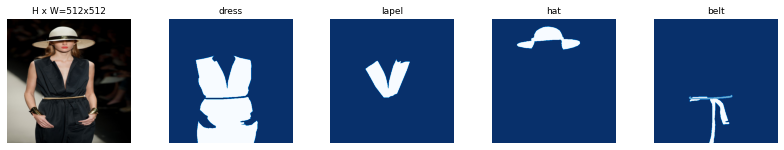

In [ ]:

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    class_ids = dataset.load_mask(image_id)[1]
    mask= dataset.load_mask(int(image_id))[0]

    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

Now, the data are partitioned into train and validation sets.

In [ ]:
# This code partially supports k-fold training, 
# you can specify the fold to train and the total number of folds here
FOLD = 0
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

Let's visualize class distributions of the train and validation data.

Total train images:  36156
Total train segments:  264949


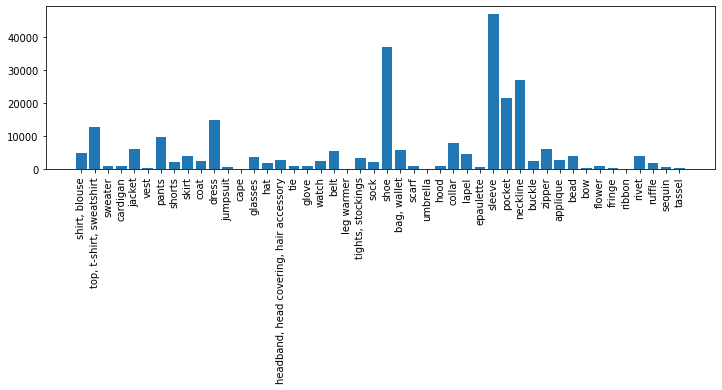

Total train images:  9039
Total validation segments:  66264


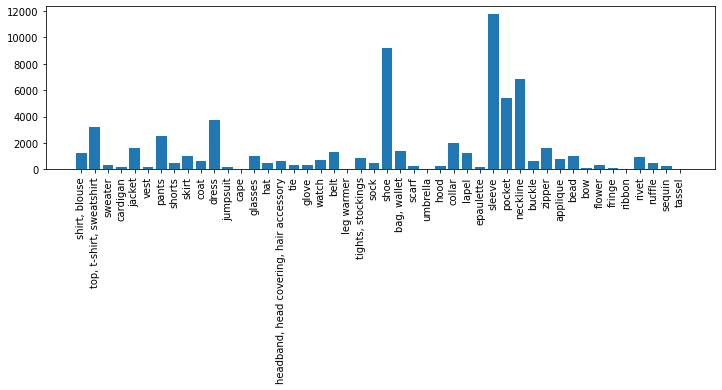

In [ ]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total train images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

# Train

In [ ]:
# Note that any hyperparameters here, such as LR, may still not be optimal
LR = 1e-4
EPOCHS = [2, 6, 8]

import warnings 
warnings.filterwarnings("ignore")

This section creates a Mask R-CNN model and specifies augmentations to be used.

In [ ]:
with tf.device('/device:GPU:0'):
  model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)
  model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=['mrcnn_class_logits', 
                                                                'mrcnn_bbox_fc', 
                                                              'mrcnn_bbox', 
                                                               'mrcnn_mask'])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

First, we train only the heads.

In [ ]:
history = {'val_loss': [2.444465160369873, 2.0658297538757324], 'val_rpn_class_loss': [0.09663911908864975, 0.08529911935329437], 'val_rpn_bbox_loss': [0.931117832660675, 0.8519657254219055], 'val_mrcnn_class_loss': [0.4743843376636505, 0.4317589998245239], 'val_mrcnn_bbox_loss': [0.4672188460826874, 0.42054930329322815], 'val_mrcnn_mask_loss': [0.49411946535110474, 0.42627862095832825], 'loss': [2.917781517982483, 2.4773499063253404], 'rpn_class_loss': [0.11658764, 0.09735176], 'rpn_bbox_loss': [1.0932739, 1.0180432], 'mrcnn_class_loss': [0.5348115, 0.46376318], 'mrcnn_bbox_loss': [0.5564421, 0.44007438], 'mrcnn_mask_loss': [0.6166656, 0.4581156]}

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2, # train heads with higher lr to speedup learning
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: /content/fashion20220511T2012/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (T

In [ ]:
print(history)
!zip -r fashion20220503T0125.zip /content/fashion20220503T0125

{'val_loss': [2.444465160369873, 2.0658297538757324], 'val_rpn_class_loss': [0.09663911908864975, 0.08529911935329437], 'val_rpn_bbox_loss': [0.931117832660675, 0.8519657254219055], 'val_mrcnn_class_loss': [0.4743843376636505, 0.4317589998245239], 'val_mrcnn_bbox_loss': [0.4672188460826874, 0.42054930329322815], 'val_mrcnn_mask_loss': [0.49411946535110474, 0.42627862095832825], 'loss': [2.917781517982483, 2.4773499063253404], 'rpn_class_loss': [0.11658764, 0.09735176], 'rpn_bbox_loss': [1.0932739, 1.0180432], 'mrcnn_class_loss': [0.5348115, 0.46376318], 'mrcnn_bbox_loss': [0.5564421, 0.44007438], 'mrcnn_mask_loss': [0.6166656, 0.4581156]}
  adding: content/fashion20220503T0125/ (stored 0%)
  adding: content/fashion20220503T0125/mask_rcnn_fashion_0001.h5 (deflated 7%)
  adding: content/fashion20220503T0125/mask_rcnn_fashion_0002.h5 (deflated 7%)
  adding: content/fashion20220503T0125/events.out.tfevents.1651541277.3b3ee54dbdf4 (deflated 70%)


In [ ]:
!ls

build			  MANIFEST.in	      README.md		setup.py
dist			  mask_rcnn_coco.h5   requirements.txt
fashion20220503T0125.zip  mask_rcnn.egg-info  samples
LICENSE			  mrcnn		      setup.cfg


In [ ]:
!cp /content/Mask_RCNN/fashion20220503T0125.zip /content/drive/MyDrive

Then, all layers are trained.

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=0.0001

Checkpoint Path: /content/fashion20220511T2012/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (B

Afterwards, we reduce LR and train again.

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR/5,
            epochs=EPOCHS[2],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 6. LR=2e-05

Checkpoint Path: /content/fashion20220511T2012/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Ba

In [ ]:
!zip -r fashion20220511T2012.zip /content/fashion20220511T2012
!cp /content/Mask_RCNN/fashion20220511T2012.zip /content/drive/MyDrive

  adding: content/fashion20220511T2012/ (stored 0%)
  adding: content/fashion20220511T2012/mask_rcnn_fashion_0005.h5 (deflated 7%)
  adding: content/fashion20220511T2012/mask_rcnn_fashion_0006.h5 (deflated 7%)
  adding: content/fashion20220511T2012/events.out.tfevents.1652306526.887745d406a0 (deflated 75%)
  adding: content/fashion20220511T2012/events.out.tfevents.1652300038.887745d406a0 (deflated 70%)
  adding: content/fashion20220511T2012/mask_rcnn_fashion_0001.h5 (deflated 7%)
  adding: content/fashion20220511T2012/mask_rcnn_fashion_0002.h5 (deflated 7%)
  adding: content/fashion20220511T2012/events.out.tfevents.1652316205.887745d406a0 (deflated 78%)
  adding: content/fashion20220511T2012/mask_rcnn_fashion_0003.h5 (deflated 7%)
  adding: content/fashion20220511T2012/mask_rcnn_fashion_0004.h5 (deflated 7%)
  adding: content/fashion20220511T2012/mask_rcnn_fashion_0007.h5 (deflated 7%)
  adding: content/fashion20220511T2012/mask_rcnn_fashion_0008.h5 (deflated 7%)


Let's visualize training history and choose the best epoch.

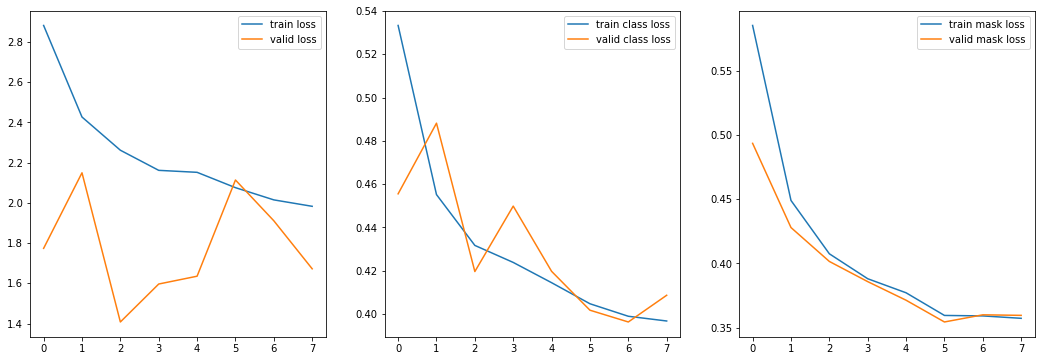

In [ ]:
epochs = range(EPOCHS[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  3
Valid loss:  1.407712459564209


# Predict

The final step is to use our model to predict test data.

In [5]:
!unzip /content/imaterialist-fashion-2019-FGVC6.zip 'test/*'
!unzip /content/imaterialist-fashion-2019-FGVC6.zip 'label_descriptions.json'
# !unzip /content/imaterialist-fashion-2019-FGVC6.zip 'train.csv'
!unzip /content/imaterialist-fashion-2019-FGVC6.zip 'sample_submission.csv'

Archive:  /content/imaterialist-fashion-2019-FGVC6.zip
  inflating: test/003d41dd20f271d27219fe7ee6de727d.jpg  
  inflating: test/0046f98599f05fd7233973e430d6d04d.jpg  
  inflating: test/004e9e21cd1aca568a8ffc77a54638ce.jpg  
  inflating: test/005b37fce3c0f641d327d95dd832f51b.jpg  
  inflating: test/0094940c58c343b742f48ae26eb5e9fa.jpg  
  inflating: test/0099bc6cd3b8c47c2d21a2877b1fa533.jpg  
  inflating: test/009b107156c1ee41b03c5b35a82e7232.jpg  
  inflating: test/00a1940434d687a785be0acf2b0fbff3.jpg  
  inflating: test/00a325fd4dc22079095ab46330abf7be.jpg  
  inflating: test/00a8764cff12b2e849c850f4be5608bc.jpg  
  inflating: test/00d5da56c02d426c4e4bf802b1888471.jpg  
  inflating: test/00d6e5891b7507fccbd49f2c2756b114.jpg  
  inflating: test/00e45dd233e31906f538ba17dd45bf29.jpg  
  inflating: test/00f1db534538841931f15f2bb5cec76c.jpg  
  inflating: test/00faa1032cc0809974a8d2dd7b018497.jpg  
  inflating: test/010cf2ab96d1d730e15c76720af0e1a6.jpg  
  inflating: test/011ccdc0d82e359

In [6]:
!rm  /content/imaterialist-fashion-2019-FGVC6.zip
!mv /content/test /content/data
!mv /content/label_descriptions.json /content/data
!mv /content/sample_submission.csv /content/data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip  /content/drive/MyDrive/fashion20220511T2012.zip  -d ./

Archive:  /content/drive/MyDrive/fashion20220511T2012.zip
   creating: ./content/fashion20220511T2012/
  inflating: ./content/fashion20220511T2012/mask_rcnn_fashion_0005.h5  
  inflating: ./content/fashion20220511T2012/mask_rcnn_fashion_0006.h5  
  inflating: ./content/fashion20220511T2012/events.out.tfevents.1652306526.887745d406a0  
  inflating: ./content/fashion20220511T2012/events.out.tfevents.1652300038.887745d406a0  
  inflating: ./content/fashion20220511T2012/mask_rcnn_fashion_0001.h5  
  inflating: ./content/fashion20220511T2012/mask_rcnn_fashion_0002.h5  
  inflating: ./content/fashion20220511T2012/events.out.tfevents.1652316205.887745d406a0  
  inflating: ./content/fashion20220511T2012/mask_rcnn_fashion_0003.h5  
  inflating: ./content/fashion20220511T2012/mask_rcnn_fashion_0004.h5  
  inflating: ./content/fashion20220511T2012/mask_rcnn_fashion_0007.h5  
  inflating: ./content/fashion20220511T2012/mask_rcnn_fashion_0008.h5  


In [18]:
best_epoch = 3
glob_list = glob.glob(f'/content/content/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
print(glob_list)
model_path = glob_list[0] if glob_list else ''
print(model_path)

['/content/content/fashion20220511T2012/mask_rcnn_fashion_0003.h5']
/content/content/fashion20220511T2012/mask_rcnn_fashion_0003.h5


This cell defines InferenceConfig and loads the best trained model.

In [21]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/content/fashion20220511T2012/mask_rcnn_fashion_0003.h5
Re-starting from epoch 3


Then, load the submission data.

In [22]:
sample_df = pd.read_csv(DATA_DIR/"sample_submission.csv")
sample_df.head()

,ImageId,EncodedPixels,ClassId
0,003d41dd20f271d27219fe7ee6de727d.jpg,1 1,23
1,0046f98599f05fd7233973e430d6d04d.jpg,1 1,23
2,004e9e21cd1aca568a8ffc77a54638ce.jpg,1 1,23
3,005b37fce3c0f641d327d95dd832f51b.jpg,1 1,23
4,0094940c58c343b742f48ae26eb5e9fa.jpg,1 1,23


Here is the main prediction steps, along with some helper functions.

In [23]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [24]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [25]:
%%time
sub_list = []
missing_count = 0
for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    image = resize_image(str(DATA_DIR/'test'/row['ImageId']))
    if (image is None) == False :    
      result = model.detect([image])[0]
      if result['masks'].size > 0:
          masks, _ = refine_masks(result['masks'], result['rois'])
          for m in range(masks.shape[-1]):
              mask = masks[:, :, m].ravel(order='F')
              rle = to_rle(mask)
              label = result['class_ids'][m] - 1
              sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
      else:
          # The system does not allow missing ids, this is an easy way to fill them 
          sub_list.append([row['ImageId'], '1 1', 23])
          missing_count += 1

  0%|          | 0/3200 [00:00<?, ?it/s]

  8%|▊         | 245/3200 [01:40<17:53,  2.75it/s]

false


 10%|█         | 320/3200 [02:06<20:03,  2.39it/s]

false


 24%|██▍       | 763/3200 [04:42<13:12,  3.07it/s]

false


 40%|████      | 1287/3200 [07:55<12:28,  2.56it/s]

false


 49%|████▉     | 1580/3200 [09:45<15:15,  1.77it/s]

false


 51%|█████     | 1636/3200 [10:06<06:16,  4.15it/s]

false


 80%|███████▉  | 2554/3200 [15:52<03:25,  3.15it/s]

false


100%|██████████| 3200/3200 [19:59<00:00,  2.67it/s]

CPU times: user 19min 16s, sys: 6min 21s, total: 25min 38s
Wall time: 19min 59s


The submission file is created, when all predictions are ready.

In [26]:
submission_df = pd.DataFrame(sub_list, columns=sample_df.columns.values)
print("Total image results: ", submission_df['ImageId'].nunique())
print("Missing Images: ", missing_count)
submission_df.head()

Total image results:  3193
Missing Images:  148


,ImageId,EncodedPixels,ClassId
0,003d41dd20f271d27219fe7ee6de727d.jpg,170449 6 170951 18 171455 28 171963 33 172473 ...,23
1,003d41dd20f271d27219fe7ee6de727d.jpg,169642 54 170154 55 170666 56 171178 57 171690...,31
2,003d41dd20f271d27219fe7ee6de727d.jpg,73066 10 73565 26 74064 40 74542 74 75049 79 7...,31
3,003d41dd20f271d27219fe7ee6de727d.jpg,,33
4,003d41dd20f271d27219fe7ee6de727d.jpg,86392 4 86904 15 86960 30 87416 90 87927 94 88...,10


In [27]:
submission_df.to_csv("submission.csv", index=False)

Finally, it's pleasing to visualize the results! Sample images contain both fashion models and predictions from the Mask R-CNN model.

In [ ]:
from pylab import imshow
import cv2
j = 0
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(DATA_DIR/'test'/image_id)
    img = cv2.imread(image_path)
    plt.figure(figsize=(25, 25))
    plt.imshow(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
        masks.shape
        rois.shape
    else:
        masks, rois = r['masks'], r['rois']
    N = rois.shape[0]
    class_names = ['bg']+label_names
    columns = 10
    rows = 2
    plt.figure(figsize=(50, 50))
    for i in range(N):
      mask = masks[:, :, i]
      #print(r['class_ids'][i])
      result_image = cv2.bitwise_and(img, img, mask = mask)
      cv2.imwrite('/segImage' +'/img' + str(j+1) + '.png', result_image)
      plt.subplot(rows, columns, i+1)
      plt.title(class_names[r['class_ids'][i]])
      plt.imshow(result_image)
      j+= 1
    #plt.show()
    #visualize.display_instances(img, rois, masks, r['class_ids'], 
     #                           ['bg']+label_names, r['scores'],
     #                           title=image_id, figsize=(12, 12))

Another way to predict


In [ ]:
from PIL import Image

def convertImage(path_image,index, save_path):
    img = Image.open(path_image)
    #img = load_rgb(path_image)
    plt.figure(figsize=(20, 20))
    plt.subplot(3, 3, index)
    img = img.convert("RGBA")
    plt.imshow(img)

    datas = img.getdata()
    print(datas)
    newData = []
  
    for items in datas:
        print(items)
        if items[0] == 0 and items[1] == 0 and items[2] == 0:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(items)
  
    img.putdata(newData)
    img.save(save_path + '/img' + str(index+1) + ".png", "PNG")
    plt.subplot(3, 3, index+1)
    plt.imshow(img)

Best epoch:  3
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/content/fashion20220511T2012/mask_rcnn_fashion_0003.h5
Re-starting from epoch 3


In [ ]:
result_images = get_all_image(folder = "result/")

In [ ]:
output_dir = "result_tranparent"
for i, image in enumerate(result_images):
  directory = "result" + str(i+1)
  directory = os.path.join(output_dir, directory)
  os.makedirs(directory, exist_ok=True)
  for j, im in enumerate(image):
    convertImage(im, j+1, directory)